Loading and preparing data: 100%|██████████| 34/34 [00:11<00:00,  2.85it/s]



Total rows loaded: 15220838
Train set size: 12,176,670
Test set size: 3,044,168

Basic Statistics:
--------------------------------------------------
        recordingId       trackId         frame  trackLifetime       xCenter  \
count  1.522084e+07  1.522084e+07  1.522084e+07   1.522084e+07  1.522084e+07   
mean   2.100819e+01  1.082531e+02  1.466739e+04   8.813412e+03  6.121910e+01   
std    8.149943e+00  1.450409e+02  8.706880e+03   9.614351e+03  3.419954e+01   
min    0.000000e+00  0.000000e+00  0.000000e+00   0.000000e+00  5.221060e+00   
25%    1.700000e+01  1.100000e+01  7.183000e+03   3.370000e+02  3.438498e+01   
50%    2.300000e+01  2.200000e+01  1.447700e+04   4.720000e+03  5.876646e+01   
75%    2.800000e+01  1.810000e+02  2.169600e+04   1.643500e+04  7.839959e+01   
max    3.200000e+01  6.120000e+02  3.320600e+04   3.320600e+04  1.849123e+02   

            yCenter       heading         width        length     xVelocity  \
count  1.522084e+07  1.522084e+07  1.522084e+07  

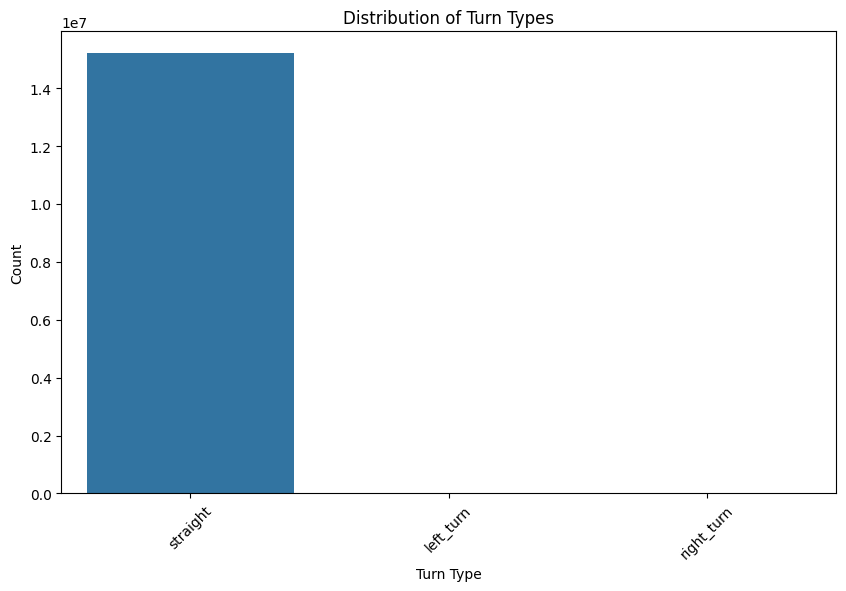

<Figure size 1200x600 with 0 Axes>

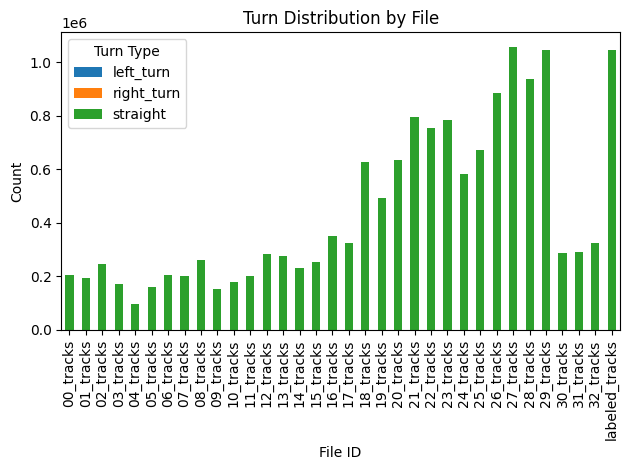


Processed data saved to 'train_data_processed.csv' and 'test_data_processed.csv'
Feature columns: ['recordingId', 'trackId', 'frame', 'trackLifetime', 'xCenter', 'yCenter', 'heading', 'width', 'length', 'xVelocity', 'yVelocity', 'xAcceleration', 'yAcceleration', 'lonVelocity', 'latVelocity', 'lonAcceleration', 'latAcceleration', 'heading_change', 'stop_before_pedestrian']


: 

In [ ]:
import os
import glob
import gc
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Configure GPU (optional - you can keep it or remove it. It does not interfere with non-model related tasks)
def configure_gpu():
    """Configures TensorFlow for optimal GPU usage on macOS (M1/M2)."""
    try:
        # Check if Metal is enabled
        import tensorflow as tf
        if tf.config.experimental.list_physical_devices('GPU'):
            print("GPU (Metal) is available.")
            # Enable mixed precision for faster training on compatible GPUs
            policy = tf.keras.mixed_precision.Policy('mixed_float16')
            tf.keras.mixed_precision.set_global_policy(policy)
            print("Mixed precision enabled.")

            # Allocate memory dynamically
            gpus = tf.config.list_physical_devices('GPU')
            if gpus:
                try:
                  for gpu in gpus:
                    tf.config.experimental.set_memory_growth(gpu, True)
                except RuntimeError as e:
                  print(e)

        else:
            print("GPU (Metal) is not available. Running on CPU.")
    except Exception as e:
        print(f"Error during GPU configuration: {e}")
        print("Running on CPU.")

# Data Loading and Preparation
class TrajectoryDataLoader:
    def __init__(self, data_dir='Tracks/', chunksize=100000):
        self.data_dir = data_dir
        self.chunksize = chunksize
        self.all_files = glob.glob(os.path.join(self.data_dir, '*tracks.csv'))
        self.all_data = None
        self.train_data = None
        self.test_data = None
        self.num_rows = 0
        self.feature_columns = None

    def _load_file(self, file_path):
        """Load a single CSV file with efficient memory usage."""
        try:
            chunks = pd.read_csv(file_path, chunksize=self.chunksize)
            df = pd.concat(chunks, ignore_index=True)
            df['file_id'] = os.path.basename(file_path).split('.')[0]
            
                    
                    
        # Optimize data types
            for col in df.select_dtypes(include=np.number).columns:
                if col in ['frame', 'trackId', 'trackLifetime']:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.float32)
            return df
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            return None

    def load_all_data(self, label_turns=True, heading_threshold=10):
        """Loads all files and labels turns."""
        all_dfs = []
        for file in tqdm(self.all_files, desc="Loading and preparing data"):
            df = self._load_file(file)
            if df is not None:
                if label_turns:
                    df = self._label_turns(df, heading_threshold=heading_threshold)
                all_dfs.append(df)
        self.all_data = pd.concat(all_dfs, ignore_index=True)
        self.num_rows = len(self.all_data)
        self.feature_columns = [col for col in self.all_data.columns if col not in ['turn_binary', 'turn_label', 'file_id']]
        print(f"\nTotal rows loaded: {self.num_rows}")

    def _label_turns(self, df, heading_threshold=10):
        """Labels turns in a dataframe using vectorized operations."""
        df['heading_change'] = df['heading'].diff().fillna(0)
        df['turn_label'] = 'straight'
        df.loc[df['heading_change'] > heading_threshold, 'turn_label'] = 'left_turn'
        df.loc[df['heading_change'] < -heading_threshold, 'turn_label'] = 'right_turn'
        df['turn_binary'] = (df['turn_label'] != 'straight').astype(np.int8)
        return df
    
    def split_data(self, test_size=0.2, random_state=42):
        """Splits the dataset into train and test sets."""
        if self.all_data is None:
            raise ValueError("Load data first using load_all_data()")

        self.train_data, self.test_data = train_test_split(self.all_data, test_size=test_size, random_state=random_state)
        print(f"Train set size: {len(self.train_data):,}")
        print(f"Test set size: {len(self.test_data):,}")

    def get_data(self):
        """Returns the data."""
        return self.train_data, self.test_data
    
    def analyze_basic_statistics(self):
        """Analyze basic statistics of the dataset"""
        print("\nBasic Statistics:")
        print("-" * 50)
        print(self.all_data.describe())
        
        print("\nMissing Values:")
        print("-" * 50)
        missing = self.all_data.isnull().sum()
        print(missing[missing > 0])

    def analyze_turn_distribution(self):
        """Analyze turn distribution and patterns"""
        print("\nTurn Distribution:")
        print("-" * 50)
        turn_dist = self.all_data['turn_label'].value_counts()
        print(turn_dist)
        
        # Plot turn distribution
        plt.figure(figsize=(10, 6))
        sns.barplot(x=turn_dist.index, y=turn_dist.values)
        plt.title('Distribution of Turn Types')
        plt.xlabel('Turn Type')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()
        
        # Turn distribution by file
        plt.figure(figsize=(12, 6))
        turn_by_file = pd.crosstab(self.all_data['file_id'], self.all_data['turn_label'])
        turn_by_file.plot(kind='bar', stacked=True)
        plt.title('Turn Distribution by File')
        plt.xlabel('File ID')
        plt.ylabel('Count')
        plt.legend(title='Turn Type')
        plt.tight_layout()
        plt.show()

# Main Execution
if __name__ == "__main__":
    # Optional: Configure GPU
    # configure_gpu()

    # Data Loading
    data_loader = TrajectoryDataLoader(chunksize=100000)
    data_loader.load_all_data()
    data_loader.split_data()
    train_data, test_data = data_loader.get_data()
    feature_columns = data_loader.feature_columns

    # Data Analysis
    data_loader.analyze_basic_statistics()
    data_loader.analyze_turn_distribution()

    # Save Processed Data
    train_data.to_csv('train_data_processed.csv', index=False)
    test_data.to_csv('test_data_processed.csv', index=False)
    print("\nProcessed data saved to 'train_data_processed.csv' and 'test_data_processed.csv'")
    print("Feature columns:", feature_columns)